In [21]:
import torchvision
import torchvision.transforms as transforms
import torch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [3]:
transform = transforms.ToTensor()

batch_size = 128

trainset = torchvision.datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

print("trainset:", len(trainset))
print("testset:", len(testset))


trainset: 60000
testset: 10000


In [4]:
# Shape of an example
print(f"Shape: {len(trainset[0][0][0])}, {len(trainset[0][0][0][0])}")

Shape: 28, 28


In [5]:
# All labels in training set
classes = set([y for _, y in trainset])
classes

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
# Function to show images
def show_imgs(imgs):
    imgs_data = [img for img, _ in imgs]
    imgs_label = [label for _, label in imgs]
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(imgs_data):
        plt.subplot(1, len(imgs_data), i+1)
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(imgs_label)

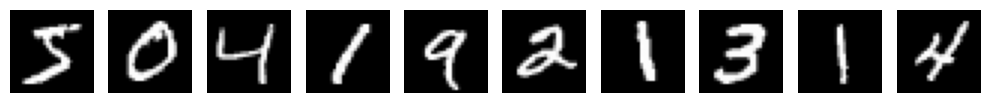

Labels: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [7]:
sample_imgs = [trainset[i] for i in range(10)]
show_imgs(sample_imgs)

In [112]:
class MNISTClassifier:
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10, xavier_init=False):

        if xavier_init:
            # uniform Xavier init
            x_min = -np.sqrt(6.0 / (input_dim + hidden_dim))
            x_max = np.sqrt(6.0 / (input_dim + hidden_dim))

            self.W1 = torch.tensor(np.random.uniform(x_min, x_max, (hidden_dim, input_dim)), requires_grad=True)
            self.W2 = torch.tensor(np.random.uniform(x_min, x_max, (output_dim, hidden_dim)), requires_grad=True)

        else:
            # random init
            scale = 0.01
            self.W1 = torch.tensor(np.random.randn(hidden_dim, input_dim) * scale, requires_grad=True)
            self.W2 = torch.tensor(np.random.randn(output_dim, hidden_dim) * scale, requires_grad=True)

        # internal biases for respective layers
        self.w1 = torch.zeros(hidden_dim, requires_grad=True)
        self.w2 = torch.zeros(output_dim, requires_grad=True)

        # prediction biases
        self.b1 = torch.zeros(hidden_dim, requires_grad=True)

    def forward(self):
        self.h1 = self.W1 @ self.x + self.w1
        self.y1 = torch.relu(self.h1) + self.b1
        self.h2 = self.W2 @ self.y1 + self.w2
        self.y2 = torch.softmax(self.h2, dim=0)
        return self.y2

    def backward(self, y_true):
        # Compute gradients
        dy2 = self.y2.clone()
        dy2[y_true] -= 1
    
        # Gradients for second layer 
        dW2 = torch.outer(dy2, self.y1)
        dw2 = dy2
        
        # First layer gradients
        dy1 = self.W2.T @ dy2 
        dh1 = dy1 * (self.h1 > 0).float()  # ReLU derivative
        dW1 = torch.outer(dh1, self.x)
        dw1 = dh1
        db1 = dy1
    
        # Update weights
        lr = 0.0001
        with torch.no_grad():
            self.W2 -= lr * dW2
            self.w2 -= lr * dw2
            self.W1 -= lr * dW1
            self.w1 -= lr * dw1
            self.b1 -= lr * db1

    def __call__(self, x):
        self.x = x
        return self.forward()

In [97]:
# Shape of single exanple
trainset[0][0].shape # requires reshaping to 784 features

x = torch.tensor(np.float64(trainset[0][0].reshape(784)))

In [98]:
# Dummy model (untrained)
dummy = MNISTClassifier()
dummy(x)
dummy_out = dummy.forward() # outputs probabilities for each class
dummy_out_df = pd.DataFrame(dummy_out.detach().numpy(), columns=["Probability"])
dummy_out_df.index.name = "Class"
display(dummy_out_df)
print(f"Actual: {trainset[0][1]}")
print(f"Prediction: {torch.argmax(dummy_out).item()}")

,Probability
Class,
0,0.099980
1,0.099050
2,0.099021
3,0.099653
4,0.101071
5,0.101111
6,0.100613
7,0.099876
8,0.101037


Actual: 5
Prediction: 5


In [99]:
# Define loss functions
def cross_entropy_loss(out, y):
    """
    cross entropy loss: -sum(true_class_distribution * log(predicted_class_distribution))
    """
    # ohe since y is scalar
    # ex. if y is 2 then y_ohe represents class distribution of 2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    y_ohe = torch.zeros_like(out)
    y_ohe[y] = 1.0

    return np.float64(-torch.sum(y_ohe * torch.log(out +1e-10)))

def mse_loss(out, y):
    out_ohe = np.zeros_like(out)
    return np.float64(np.sum((out_ohe - y)**2))

In [100]:
def criterion(y_pred, y_true, loss_fn):
    return loss_fn(y_pred, y_true)

In [101]:
# Test the loss functions
y_true = 5
y_pred = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.1, 0.1, 0.1, 0.1])

ce = cross_entropy_loss(y_pred, y_true)
mse = mse_loss(y_pred, y_true)

print("Cross-entropy loss:", ce)
print("MSE loss:", mse)

Cross-entropy loss: 0.6931471824645996
MSE loss: 250.0


In [108]:
EPOCHS = 10
losses = {
    "base": [],
    "xavier": []
}

In [109]:
base = MNISTClassifier()

# Classic old gradient descent
for epoch in range(EPOCHS):
    epoch_loss = 0
    
    for i in range(len(trainset)):
        img, label = trainset[i]
        x = torch.tensor(np.float64(img.reshape(784)))

        output = base(x)

        loss = criterion(output, label, cross_entropy_loss)
        epoch_loss += loss
        
        base.backward(label)
        
        if i % 1000 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')

    avg_loss = epoch_loss / len(trainset)
    losses["base"].append(avg_loss.item())
    print(f'Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')

Epoch [1/10], Step [0/60000], Loss: 2.3165
Epoch [1/10], Step [1000/60000], Loss: 2.3065
Epoch [1/10], Step [2000/60000], Loss: 2.3093
Epoch [1/10], Step [3000/60000], Loss: 2.2918
Epoch [1/10], Step [4000/60000], Loss: 2.2858
Epoch [1/10], Step [5000/60000], Loss: 2.2878
Epoch [1/10], Step [6000/60000], Loss: 2.2884
Epoch [1/10], Step [7000/60000], Loss: 2.2997
Epoch [1/10], Step [8000/60000], Loss: 2.2928
Epoch [1/10], Step [9000/60000], Loss: 2.3049
Epoch [1/10], Step [10000/60000], Loss: 2.2760
Epoch [1/10], Step [11000/60000], Loss: 2.2706
Epoch [1/10], Step [12000/60000], Loss: 2.2790
Epoch [1/10], Step [13000/60000], Loss: 2.2742
Epoch [1/10], Step [14000/60000], Loss: 2.2754
Epoch [1/10], Step [15000/60000], Loss: 2.3426
Epoch [1/10], Step [16000/60000], Loss: 2.2769
Epoch [1/10], Step [17000/60000], Loss: 2.2454
Epoch [1/10], Step [18000/60000], Loss: 2.2810
Epoch [1/10], Step [19000/60000], Loss: 2.2712
Epoch [1/10], Step [20000/60000], Loss: 2.3440
Epoch [1/10], Step [21000/

In [113]:
xavier = MNISTClassifier(xavier_init=True)

for epoch in range(EPOCHS):
    epoch_loss = 0
    
    for i in range(len(trainset)):
        img, label = trainset[i]
        x = torch.tensor(np.float64(img.reshape(784)))

        output = xavier(x)

        loss = criterion(output, label, cross_entropy_loss)
        epoch_loss += loss
        
        xavier.backward(label)
        
        if i % 1000 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')

    avg_loss = epoch_loss / len(trainset)
    losses["xavier"].append(avg_loss.item())
    print(f'Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')

Epoch [1/10], Step [0/60000], Loss: 2.3513
Epoch [1/10], Step [1000/60000], Loss: 2.2764
Epoch [1/10], Step [2000/60000], Loss: 2.2105
Epoch [1/10], Step [3000/60000], Loss: 2.4721
Epoch [1/10], Step [4000/60000], Loss: 2.1118
Epoch [1/10], Step [5000/60000], Loss: 1.9628
Epoch [1/10], Step [6000/60000], Loss: 2.0864
Epoch [1/10], Step [7000/60000], Loss: 2.1576
Epoch [1/10], Step [8000/60000], Loss: 1.6756
Epoch [1/10], Step [9000/60000], Loss: 2.0668
Epoch [1/10], Step [10000/60000], Loss: 1.8676
Epoch [1/10], Step [11000/60000], Loss: 1.6969
Epoch [1/10], Step [12000/60000], Loss: 1.9642
Epoch [1/10], Step [13000/60000], Loss: 1.9645
Epoch [1/10], Step [14000/60000], Loss: 1.9360
Epoch [1/10], Step [15000/60000], Loss: 2.2538
Epoch [1/10], Step [16000/60000], Loss: 1.5236
Epoch [1/10], Step [17000/60000], Loss: 1.7780
Epoch [1/10], Step [18000/60000], Loss: 1.9978
Epoch [1/10], Step [19000/60000], Loss: 1.4773
Epoch [1/10], Step [20000/60000], Loss: 2.0875
Epoch [1/10], Step [21000/

In [114]:
# Calculate variance of losses
# var = std^2 = sum((x - mean)^2) / n
for type in losses:
    all_losses = losses[type]
    n = len(all_losses)
    mean = sum(all_losses) / n

    var = sum((x - mean) ** 2 for x in all_losses) / n
    print(f"{type} {mean=:.2f}")
    print(f"{type} {var=:.2f}")

base mean=0.66
base var=0.30
xavier mean=0.50
xavier var=0.12


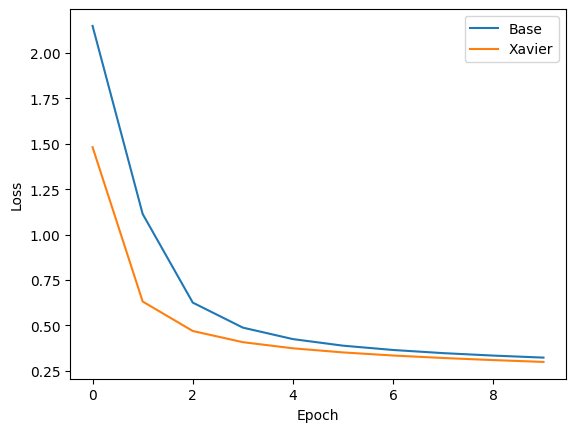

In [115]:
# Plot losses of base and xavier init
plt.plot(losses["base"], label="Base")
plt.plot(losses["xavier"], label="Xavier")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [124]:
results = {
    "base": [],
    "xavier": []
}

In [125]:
# Testing loop
test_loss = 0
correct = 0

for i in range(len(testset)):
   img, label = testset[i]
   x = torch.tensor(np.float64(img.reshape(784)))

   output = base(x)
   loss = criterion(output, label, cross_entropy_loss)
   test_loss += loss
   
   pred = torch.argmax(output)
   correct += (pred == label).item()
   
   if i % 1000 == 0:
       print(f'Step [{i}/{len(testset)}], Loss: {loss:.4f}')

avg_test_loss = test_loss / len(testset)
accuracy = 100 * correct / len(testset)
results["base"].append(accuracy)

print(f'{avg_test_loss=:.4f}, {accuracy=:.2f}%')

Step [0/10000], Loss: 0.0042
Step [1000/10000], Loss: 0.5232
Step [2000/10000], Loss: 0.0335
Step [3000/10000], Loss: 0.1301
Step [4000/10000], Loss: 2.0359
Step [5000/10000], Loss: 0.4795
Step [6000/10000], Loss: 0.1709
Step [7000/10000], Loss: 0.0276
Step [8000/10000], Loss: 0.0008
Step [9000/10000], Loss: 0.0029
avg_test_loss=0.3050, accuracy=91.23%


In [126]:
# Testing loop
test_loss = 0
correct = 0

for i in range(len(testset)):
   img, label = testset[i]
   x = torch.tensor(np.float64(img.reshape(784)))

   output = xavier(x)
   loss = criterion(output, label, cross_entropy_loss)
   test_loss += loss
   
   pred = torch.argmax(output)
   correct += (pred == label).item()
   
   if i % 1000 == 0:
       print(f'Step [{i}/{len(testset)}], Loss: {loss:.4f}')

avg_test_loss = test_loss / len(testset)
accuracy = 100 * correct / len(testset)
results["xavier"].append(accuracy)

print(f'{avg_test_loss=:.4f}, {accuracy=:.2f}%')

Step [0/10000], Loss: 0.0025
Step [1000/10000], Loss: 0.3515
Step [2000/10000], Loss: 0.0439
Step [3000/10000], Loss: 0.1075
Step [4000/10000], Loss: 1.9463
Step [5000/10000], Loss: 0.4231
Step [6000/10000], Loss: 0.2531
Step [7000/10000], Loss: 0.0212
Step [8000/10000], Loss: 0.0006
Step [9000/10000], Loss: 0.0027
avg_test_loss=0.2829, accuracy=92.12%


In [129]:
results_df = pd.DataFrame(results, index=["Accuracy"])
results_df

,base,xavier
Accuracy,91.23,92.12


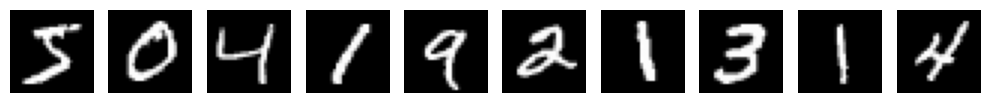

Labels: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


,actual,predicted
0,5,5
1,0,0
2,4,4
3,1,1
4,9,9
5,2,2
6,1,1
7,3,3
8,1,1
9,4,4


In [41]:
# Let's use the original sample images
show_imgs(sample_imgs)

pred = { "actual": [y for _, y in sample_imgs], "predicted": [torch.argmax(base.forward(torch.tensor(np.float64(img.reshape(784))))).item() for img, _ in sample_imgs] }
pred_df = pd.DataFrame(pred,)
pred_df